In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

In [38]:
def grid(h):  # h in mm
    nx = int(70 / h) + 1
    ny = int(20 / h) + 1

    xvals = np.linspace(0, 70, nx)
    yvals = np.linspace(0, 20, ny)
    return nx, ny, xvals, yvals

In [39]:
def init(nx, ny, h):
    u = np.zeros((nx, ny), dtype=float)  # stream function
    w = np.zeros((nx, ny), dtype=float)  # vorticity field 
    v0 = 1.0 #fix these values
    omega = 1.1
    nu = 1
    iter = 0
    R = v0*h/nu
    return u, w, v0, omega, nu, iter, R

In [40]:
def edges(nx, ny, u, w, v0, IL, T, h = 1):
    for i in range(nx):
        for j in range(ny): 
            w[i,j] = 0.0
            u[i,j] = j * v0  

    for i in range(nx):
        u[i,ny-1] = u[i, ny-2] + v0 * h 
        w[i,ny-2] = 0.0

    for j in range(ny):
        u[1,j] = u[0,j]
        w[0,j] = 0.0

    for i in range(0, nx):
        if i <= IL or i >= IL + T:
            u[i,0] = 0.0
            w[i,0] = 0.0

    for j in range(1, ny-1):
        u[nx-1,j] = u[nx-2,j]
        w[nx-1,j] = w[nx-2,j]

    return u, w

In [41]:
def beam(u, w, H, IL, T, h):
    
    for i in range (H+1): #beam side
        w[IL,i] = -2 * u[IL-1, i]/(h * h)
        w[IL + T, i] = -2 * u[IL + T + 1, i]/(h * h)

    for j in range(IL, IL + T + 1): #beam top
        w[j, H-1] = -2 * u[j, H]/(h * h)

    for i in range(0, H + 1): # u = 0 on beam surfaces
        u[IL,i] = 0.0
        u[IL+T,i] = 0.0
    for j in range(IL, IL + T + 1):
        u[j,H] = 0.0
    return u, w

In [42]:
#@numba.jit(nopython=True)
def relax(nx, ny, u, w, R, omega, h, IL, T, H):
    u, w = beam(u, w, H, IL, T, h)

    for i in range(1,nx-1): 
        for j in range(1,ny-1):
            r1 = omega * ((u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] + h*h*w[i,j])*0.25 - u[i,j])
            u[i,j] += r1

    for i in range(1, nx-1):
        for j in range(1, ny-1):
            a1 = w[i+1,j] + w[i-1,j] + w[i,j+1] + w[i, j-1]
            a2 = (u[i, j+1] - u[i, j-1]) * (w[i+1,j] - w[i-1,j])
            a3 = (u[i+1, j] - u[i-1,j]) * (w[i,j+1] - w[i,j-1])
            r2 = omega * ((a1 - (R/4.0)*(a2 - a3))/4.0 - w[i,j])
            w[i,j] += r2
    return u, w
            

In [43]:
H = 8  # height of beam
IL = 35  # initial length of beam
T = 8   # thickness of beam
h = 1   # grid spacing


print("init")
nx, ny, xvals, yvals = grid(h)
u, w, v0, omega, nu, iter, R = init (nx, ny, h)

print("BC")
u, w = edges (nx, ny, u, w, v0, IL, T, h)
u, w = beam(u, w, H, IL, T, h)

print("relax")
maxiter = 100
for iter in range(maxiter):
    u, w = relax(nx, ny, u, w, R, omega, h, IL, T, H)
    if iter % 10 == 0:
        print(f"Iteration: {iter}")

print("plot")
# Create proper meshgrid for plotting
x = np.linspace(0, 70, nx)  # Use array indices for plotting
y = np.linspace(0, 20, ny)
X, Y = np.meshgrid(x, y, indexing='ij')  # Important: match array indexing


init
BC
relax
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
plot


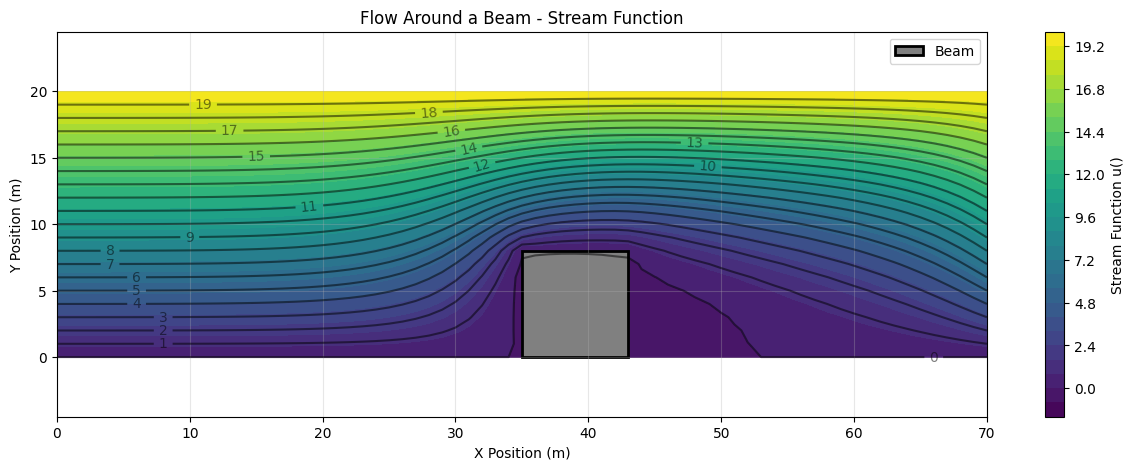

In [44]:
plt.figure(figsize=(15, 5))
contour = plt.contourf(X, Y, u, levels=30)
plt.colorbar(contour, label='Stream Function u()')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('2D Stream Function Contours - Flow Around Beam')
plt.axis('equal')

# Add beam
plt.fill([IL, IL+T, IL+T, IL], [0, 0, H, H], color = 'gray', label='Beam', edgecolor='black', linewidth=2)
plt.clabel(plt.contour(X, Y, u, levels=20, colors='k', alpha=0.5), inline=True)

plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Flow Around a Beam - Stream Function')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

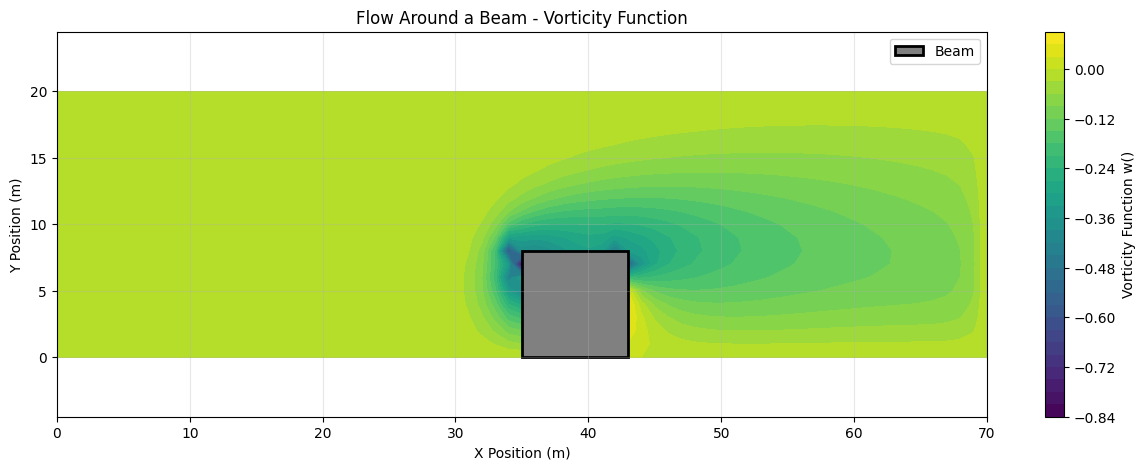

In [45]:
plt.figure(figsize=(15, 5))
contour = plt.contourf(X, Y, w, levels=30)
plt.colorbar(contour, label='Vorticity Function w()')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('2D Vorticity Function Contours - Flow Around Beam')
plt.axis('equal')

# Add beam
plt.fill([IL, IL+T, IL+T, IL], [0, 0, H, H], color = 'gray', label='Beam', edgecolor='black', linewidth=2)

plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Flow Around a Beam - Vorticity Function')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()